In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from scipy.cluster import hierarchy as hc
import sklearn.decomposition
import sklearn.preprocessing
import lightgbm as lgb
import seaborn as sns
from statsmodels.tsa.tsatools import lagmat
import copy

sns.set()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# load datasets, remove the first 'unnamed' columns

train_fault_free = pd.read_csv('/content/drive/MyDrive/Thesis/TEP_FaultFree_Training.csv').iloc[:,1:]
test_faulty = pd.read_csv('/content/drive/MyDrive/Thesis/TEP_Faulty_Training.csv').iloc[:,1:]

In [ ]:
# @title
# rename stuff according to this paper: https://www.sciencedirect.com/science/article/pii/S0098135414000969?via%3Dihub
'''
X_dict = {
'XMEAS_1':'A_feed_stream',
'XMEAS_2':'D_feed_stream',
'XMEAS_3':'E_feed_stream',
'XMEAS_4':'Total_fresh_feed_stripper',
'XMEAS_5':'Recycle_flow_into_rxtr',
'XMEAS_6':'Reactor_feed_rate',
'XMEAS_7':'Reactor_pressure',
'XMEAS_8':'Reactor_level',
'XMEAS_9':'Reactor_temp',
'XMEAS_10':'Purge_rate',
'XMEAS_11':'Separator_temp',
'XMEAS_12':'Separator_level',
'XMEAS_13':'Separator_pressure',
'XMEAS_14':'Separator_underflow',
'XMEAS_15':'Stripper_level',
'XMEAS_16':'Stripper_pressure',
'XMEAS_17':'Stripper_underflow',
'XMEAS_18':'Stripper_temperature',
'XMEAS_19':'Stripper_steam_flow',
'XMEAS_20':'Compressor_work',
'XMEAS_21':'Reactor_cooling_water_outlet_temp',
'XMEAS_22':'Condenser_cooling_water_outlet_temp',
'XMEAS_23':'Composition_of_A_rxtr_feed',
'XMEAS_24':'Composition_of_B_rxtr_feed',
'XMEAS_25':'Composition_of_C_rxtr_feed',
'XMEAS_26':'Composition_of_D_rxtr_feed',
'XMEAS_27':'Composition_of_E_rxtr_feed',
'XMEAS_28':'Composition_of_F_rxtr_feed',
'XMEAS_29':'Composition_of_A_purge',
'XMEAS_30':'Composition_of_B_purge',
'XMEAS_31':'Composition_of_C_purge',
'XMEAS_32':'Composition_of_D_purge',
'XMEAS_33':'Composition_of_E_purge',
'XMEAS_34':'Composition_of_F_purge',
'XMEAS_35':'Composition_of_G_purge',
'XMEAS_36':'Composition_of_H_purge',
'XMEAS_37':'Composition_of_D_product',
'XMEAS_38':'Composition_of_E_product',
'XMEAS_39':'Composition_of_F_product',
'XMEAS_40':'Composition_of_G_product',
'XMEAS_41':'Composition_of_H_product',
'XMV_1':'D_feed_flow_valve',
'XMV_2':'E_feed_flow_valve',
'XMV_3':'A_feed_flow_valve',
'XMV_4':'Total_feed_flow_stripper_valve',
'XMV_5':'Compressor_recycle_valve',
'XMV_6':'Purge_valve',
'XMV_7':'Separator_pot_liquid_flow_valve',
'XMV_8':'Stripper_liquid_product_flow_valve',
'XMV_9':'Stripper_steam_valve',
'XMV_10':'Reactor_cooling_water_flow_valve',
'XMV_11':'Condenser_cooling_water_flow_valve',
'XMV_12':'Agitator_speed'
   }

train_fault_free = train_fault_free.rename(columns = lambda x:X_dict[x.upper()] if x.upper() in X_dict.keys()  else x)
test_faulty = test_faulty.rename(columns = lambda x:X_dict[x.upper()] if x.upper() in X_dict.keys()  else x)
'''

"\nX_dict = {\n'XMEAS_1':'A_feed_stream',\n'XMEAS_2':'D_feed_stream',\n'XMEAS_3':'E_feed_stream',\n'XMEAS_4':'Total_fresh_feed_stripper',\n'XMEAS_5':'Recycle_flow_into_rxtr',\n'XMEAS_6':'Reactor_feed_rate',\n'XMEAS_7':'Reactor_pressure',\n'XMEAS_8':'Reactor_level',\n'XMEAS_9':'Reactor_temp',\n'XMEAS_10':'Purge_rate',\n'XMEAS_11':'Separator_temp',\n'XMEAS_12':'Separator_level',\n'XMEAS_13':'Separator_pressure',\n'XMEAS_14':'Separator_underflow',\n'XMEAS_15':'Stripper_level',\n'XMEAS_16':'Stripper_pressure',\n'XMEAS_17':'Stripper_underflow',\n'XMEAS_18':'Stripper_temperature',\n'XMEAS_19':'Stripper_steam_flow',\n'XMEAS_20':'Compressor_work',\n'XMEAS_21':'Reactor_cooling_water_outlet_temp',\n'XMEAS_22':'Condenser_cooling_water_outlet_temp',\n'XMEAS_23':'Composition_of_A_rxtr_feed',\n'XMEAS_24':'Composition_of_B_rxtr_feed',\n'XMEAS_25':'Composition_of_C_rxtr_feed',\n'XMEAS_26':'Composition_of_D_rxtr_feed',\n'XMEAS_27':'Composition_of_E_rxtr_feed',\n'XMEAS_28':'Composition_of_F_rxtr_feed',\

In [3]:
X_dict = {
'XMEAS_1':'XMEAS1',
'XMEAS_2':'XMEAS2',
'XMEAS_3':'XMEAS3',
'XMEAS_4':'XMEAS4',
'XMEAS_5':'XMEAS5',
'XMEAS_6':'XMEAS6',
'XMEAS_7':'XMEAS7',
'XMEAS_8':'XMEAS8',
'XMEAS_9':'XMEAS9',
'XMEAS_10':'XMEAS10',
'XMEAS_11':'XMEAS11',
'XMEAS_12':'XMEAS12',
'XMEAS_13':'XMEAS13',
'XMEAS_14':'XMEAS14',
'XMEAS_15':'XMEAS15',
'XMEAS_16':'XMEAS16',
'XMEAS_17':'XMEAS17',
'XMEAS_18':'XMEAS18',
'XMEAS_19':'XMEAS19',
'XMEAS_20':'XMEAS20',
'XMEAS_21':'XMEAS21',
'XMEAS_22':'XMEAS22',
'XMEAS_23':'XMEAS23',
'XMEAS_24':'XMEAS24',
'XMEAS_25':'XMEAS25',
'XMEAS_26':'XMEAS26',
'XMEAS_27':'XMEAS27',
'XMEAS_28':'XMEAS28',
'XMEAS_29':'XMEAS29',
'XMEAS_30':'XMEAS30',
'XMEAS_31':'XMEAS31',
'XMEAS_32':'XMEAS32',
'XMEAS_33':'XMEAS33',
'XMEAS_34':'XMEAS34',
'XMEAS_35':'XMEAS35',
'XMEAS_36':'XMEAS36',
'XMEAS_37':'XMEAS37',
'XMEAS_38':'XMEAS38',
'XMEAS_39':'XMEAS39',
'XMEAS_40':'XMEAS40',
'XMEAS_41':'XMEAS41',
'XMV_1':'XMV1',
'XMV_2':'XMV2',
'XMV_3':'XMV3',
'XMV_4':'XMV4',
'XMV_5':'XMV5',
'XMV_6':'XMV6',
'XMV_7':'XMV7',
'XMV_8':'XMV8',
'XMV_9':'XMV9',
'XMV_10':'XMV10',
'XMV_11':'XMV11',
'XMV_12':'XMV12'
   }

train_fault_free = train_fault_free.rename(columns = lambda x:X_dict[x.upper()] if x.upper() in X_dict.keys()  else x)
test_faulty = test_faulty.rename(columns = lambda x:X_dict[x.upper()] if x.upper() in X_dict.keys()  else x)

In [6]:
train_df = train_fault_free[train_fault_free.simulationRun==1].iloc[:,3:]

# what do the fault-free features actually look like?

fig, ax = plt.subplots(13,4,figsize=(30,50))

for i in range(train_df.shape[1]):
    train_df.iloc[:,i].plot(ax=ax.ravel()[i])
    ax.ravel()[i].legend();

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_fault7_run1 = test_faulty[(test_faulty.faultNumber==7) & (test_faulty.simulationRun==1)].iloc[:,3:]

# now plot features with fault type 7 for the first simulation run

fig, ax = plt.subplots(13,4,figsize=(30,50))

for i in range(test_fault7_run1.shape[1]):
    test_fault7_run1.iloc[:,i].plot(ax=ax.ravel()[i])
    ax.ravel()[i].legend();

Output hidden; open in https://colab.research.google.com to view.

In [5]:
# visualize the Spearman correlations

corr = np.round(scipy.stats.spearmanr(train_df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=train_df.columns, orientation='right', leaf_font_size=8)
plt.show()

# features that have less vertical distance between them are more similar to each other


NameError: name 'train_df' is not defined

In [ ]:
corr_condensed

array([0.982 , 1.2333, 1.1747, ..., 0.9854, 1.066 , 0.949 ])

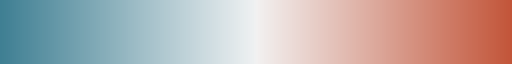

In [ ]:
custom_palette = sns.diverging_palette(220, 20, as_cmap=True)
custom_palette

NameError: name 'corr' is not defined

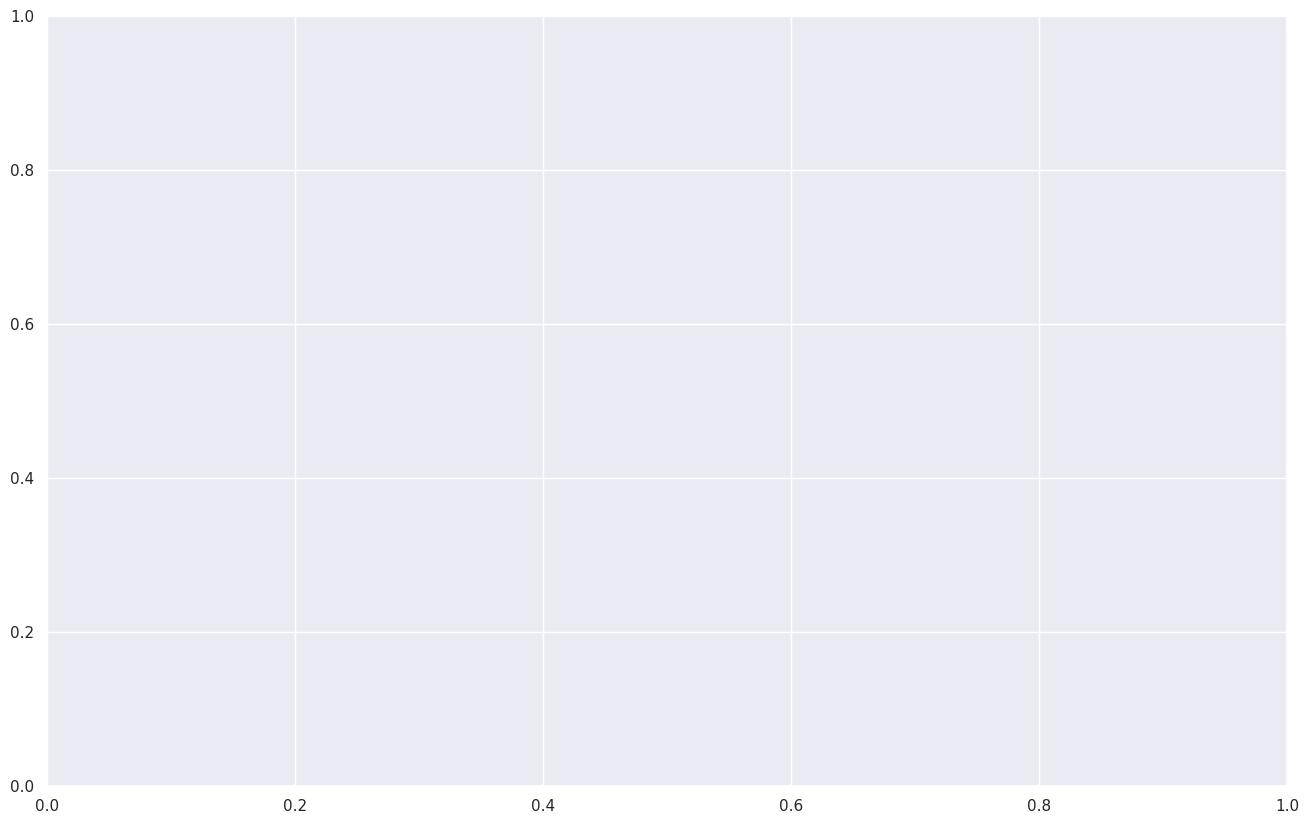

In [4]:
fig, ax = plt.subplots(figsize=(16, 10))

# Use sns.heatmap to create the heatmap


sns.heatmap(corr,
            annot=False,  # Display correlation values in the cells
            cmap='BrBG',  # Choose a colormap ---- icefire
            xticklabels=train_df.columns,  # Label x-axis with column names
            yticklabels=train_df.columns,  # Label y-axis with column names
            ax=ax)

<Axes: >

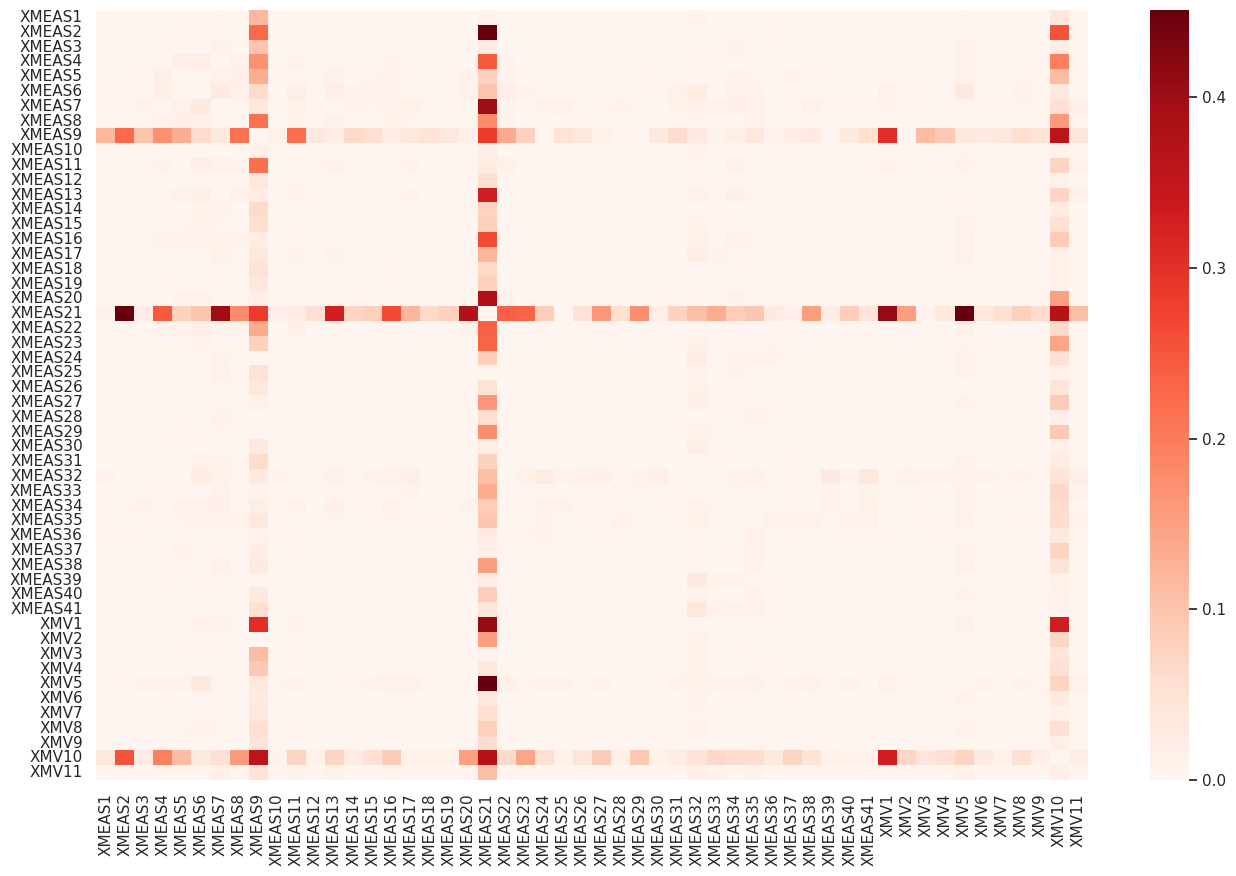

In [25]:
train_df = train_fault_free[train_fault_free.simulationRun==1].iloc[:,3:]
test_df = test_faulty[(test_faulty.faultNumber==14) & (test_faulty.simulationRun==1)].iloc[:,3:]
corr = np.round(scipy.stats.spearmanr(train_df).correlation, 4)
corr_fault = np.round(scipy.stats.spearmanr(test_df).correlation, 4)
delta_corr = np.abs(corr_fault - corr)
fig, ax = plt.subplots(figsize=(16, 10))

# Use sns.heatmap to create the heatmap


sns.heatmap(delta_corr,
            annot=False,  # Display correlation values in the cells
            #cmap='BrBG',  # Choose a colormap ---- icefire
            cmap = 'Reds',
            xticklabels=train_df.columns,  # Label x-axis with column names
            yticklabels=train_df.columns,  # Label y-axis with column names
            ax=ax)

In [ ]:
# PRINCIPAL COMPONENT ANALYSIS (PCA)

class ModelPCA ():

    def squared_prediction_error(self, X, X_pred):
        return np.sum((X-X_pred)**2, axis=1)

    def train(self, train_df, plot = False):

        self.mu_train = train_df.mean(axis=0)
        self.sigma_train = train_df.std(axis=0)

        # create the PCA model
        self.m = sklearn.decomposition.PCA(n_components = 0.9)
            # the n_components value determines the fraction of variation in the data to be explained
            # it basically means that the PCA will keep as many principal components as needed to explain for 90% of the variation in the data

        X_train = sklearn.preprocessing.scale(train_df)
            # scale the dataframe so that it has a mean of 0 and a variance of 1

        X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train))
            # think of PCA as a machine that highlights the most important stuff in your data
            # the data is represented by a set of new axes, called the principal components
            # these axes capture the most significant patterns and variations in the data
            # feed X_train into this machine and it identifies how the features vary
            # inverse transform the transformed version of X_train
            # this isn't just a "reverse" process, you're bringing back the transformed data that captured the most significant patterns
            # use this data as the predictions to compare with


        if plot:
            fig, ax = plt.subplots()
            plt.subplots_adjust(top=0.85, hspace=0.5)
            xaxis = np.arange(len(self.m.explained_variance_ratio_))
            ax.bar(xaxis, self.m.explained_variance_ratio_)
            ax.plot(xaxis, np.cumsum(self.m.explained_variance_ratio_));
            ax.set_xlabel('Principal component')
            ax.set_ylabel('Cumulative variance explained')
            ax.set_title('PCA - Explained variance');

        return self.squared_prediction_error(X_train, X_train_pred)

    def test(self, test_df, plot = False):

        X_test = np.array((test_df-self.mu_train)/self.sigma_train)
            # calculate (x-mu)/sigma
        X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.squared_prediction_error(X_test, X_test_pred)

In [ ]:
# Light Gradient Boosting (LGB)

class ModelEnsembleRegressors():

    def __init__ (self, regressor, **kwargs):
        self.regressor = regressor
        self.kwargs = kwargs

    def squared_prediction_error(self, y, y_pred):
        return (y-y_pred)**2

    def train(self, train_df, plot = False):

        self.mu_train = train_df.mean(axis=0)
        self.sigma_train = train_df.std(axis=0)

        self.models = {}
            # initiate empty dictionary to store trained models
        spe_df = pd.DataFrame()
            # initiate empty dataframe

        cols_to_predict = train_df.columns
            # these are the features we want to predict

        index = 0 # counter for plot positions

        self.to_predict_test = [] # empty list to store column names during testing

        if plot:
            n_rows = int(np.ceil(len(train_df.columns)/4))
            fig, ax = plt.subplots(n_rows,4,figsize=(30,4*n_rows))
            plt.subplots_adjust(top=0.85, hspace=0.5)

        for col in train_df.columns:

            print('training model for', col)
            model = self.regressor(**self.kwargs)
            train_x = sklearn.preprocessing.scale(train_df.drop([col], axis=1))
            train_y = sklearn.preprocessing.scale(train_df[col])

            model.fit(X = train_x, y = train_y)

            train_y_pred = model.predict(X = train_x)

            self.models[col] = model

            spe_df[col] = self.squared_prediction_error(train_y, train_y_pred)
                # store the spe values in spe_df for each column in train_df

            self.to_predict_test.append(col)

            if plot:
                ax.ravel()[index].plot(train_y, alpha=0.5, color='blue')
                ax.ravel()[index].plot(train_y_pred, alpha=0.5, color='red')
                ax.ravel()[index].set_title(f'{col} - SPE = {np.mean(spe_df[col]):.2f}')

            index += 1

        return np.mean(spe_df, axis=1)

    def test(self, test_df, plot = False):

        spe_df = pd.DataFrame()

        index = 0

        if plot:
            n_rows = int(np.ceil(len(train_df.columns)/4))
            fig, ax = plt.subplots(n_rows,4,figsize=(30,4*n_rows))
            plt.subplots_adjust(top=0.85, hspace=0.5)

        for col in self.to_predict_test:
            test_x = np.array((test_df.drop([col],axis=1)-self.mu_train.drop([col]))/self.sigma_train.drop([col]))
            test_y = np.array((test_df[col]-self.mu_train[col])/self.sigma_train[col])
            test_y_pred = self.models[col].predict(test_x)
            spe_df[col] = self.squared_prediction_error(test_y, test_y_pred)

            if plot:
                ax.ravel()[index].plot(test_y, alpha=0.5, color='blue')
                ax.ravel()[index].plot(test_y_pred, alpha=0.5, color='red')
                ax.ravel()[index].set_title(f'{col}/SPE = {np.mean(spe_df[col]):.2f}')

            index += 1

        return np.mean(spe_df, axis=1)

In [ ]:
# Lagging data
# to implement dynamic principal component analysis (DPCA)

def apply_lag (dataframe, lag=1):


    lagged_array = lagmat(dataframe, maxlag=lag, trim='forward', original='in')[lag:,:]
    new_columns = []
    for i in range(lag):
        new_columns.append(dataframe.columns + '_lag' + str(i + 1))
    lagged_columns = dataframe.columns.append(new_columns)
    lagged_index = dataframe.index[lag:]
    lagged_dataframe = pd.DataFrame(lagged_array, index=lagged_index, columns=lagged_columns)

    return lagged_dataframe

In [ ]:
# Moving average noise filter

def filter_noise_ma(dataframe, window_size=100, reduction=False):

    new_dataframe = copy.deepcopy(dataframe)

    for column in dataframe:
        new_dataframe[column] = new_dataframe[column].rolling(window_size).mean()

    if reduction:
        return new_dataframe.drop(dataframe.index[:window_size])[::window_size]
    else:
        return new_dataframe.drop(dataframe.index[:window_size])

# **TRAINING**

In [ ]:
# define training, validation and testing datasets using fault free data

train_df        = train_fault_free[train_fault_free.simulationRun==1].iloc[:,3:]
validation_df   = train_fault_free[(train_fault_free.simulationRun>1)&(train_fault_free.simulationRun<5)].iloc[:,3:]
test_df         = train_fault_free[(train_fault_free.simulationRun>5)&(train_fault_free.simulationRun<10)].iloc[:,3:]

regression_method = lgb.LGBMRegressor

models = {'pca': ModelPCA(), 'lgb': ModelEnsembleRegressors(regression_method)}
detection_limits = {}

fig, ax = plt.subplots(len(models),3, figsize=(20,4*len(models)))
plt.subplots_adjust(top=0.85, hspace=0.5)

i = 0

for name, model in models.items():
    # name is the key (either 'pca' or 'lgb') and model is the corresponding instance of the class

    # train, validate and test using the data defined earlier
    spe_train       = model.train(train_df, plot=True)
    spe_validation  = model.test(validation_df, plot=True)
    spe_test        = model.test(test_df)

    detection_limits[name] = np.percentile(spe_validation, 99.99)
        # anything beyond the 99.99th percentile is an obvious anomaly

    ax[i,0].plot(spe_train)
    ax[i,1].plot(spe_validation)
    ax[i,2].plot(spe_test)

    ax[i,0].set_title(f'Training - {name}')
    ax[i,1].set_title(f'Validation - {name}')
    ax[i,2].set_title(f'Test - {name}')

    ax[i, 0].set_xlabel('Sample')
    ax[i, 1].set_xlabel('Sample')
    ax[i, 2].set_xlabel('Sample')

    ax[i, 0].set_ylabel('Squared Prediction Error')
    ax[i, 1].set_ylabel('Squared Prediction Error')
    ax[i, 2].set_ylabel('Squared Prediction Error')

    ax[i,1].axhline(detection_limits[name], ls = '--')
    ax[i,2].axhline(detection_limits[name], ls = '--')

    i += 1

fig.suptitle('Squared Prediction Error')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
models

{'pca': <__main__.ModelPCA at 0x79b7d5c450f0>,
 'lgb': <__main__.ModelEnsembleRegressors at 0x79b7d5c45660>}

# **TESTING**

In [ ]:
models.items()

dict_items([('pca', <__main__.ModelPCA object at 0x7c8a82f36b60>), ('lgb', <__main__.ModelEnsembleRegressors object at 0x7c8a82f36ec0>)])

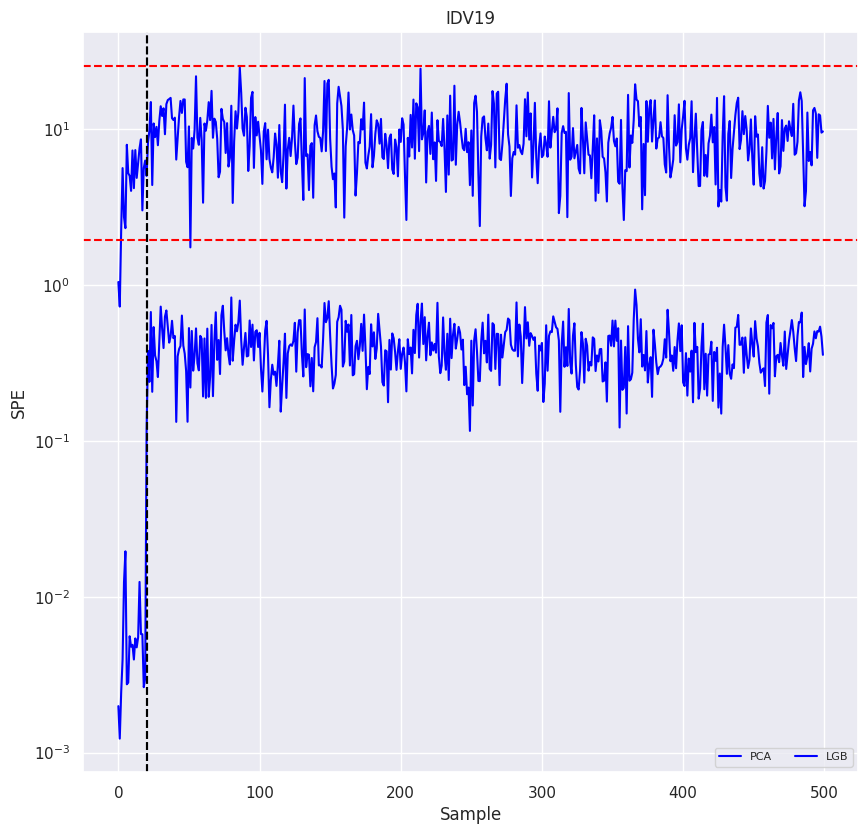

pca    55.802083
lgb    50.250000
dtype: float64


IDV1       IDV2  IDV3       IDV4       IDV5   IDV6        IDV7  \
pca  99.375  96.875000   0.0  70.000000  18.958333  100.0   98.333333   
lgb  98.750  96.666667   0.0   0.208333  33.125000  100.0  100.000000   

          IDV8  IDV9      IDV10      IDV11   IDV12  IDV13      IDV14  IDV15  \
pca  88.958333   0.0  20.208333  34.583333  84.375  92.50  99.791667    0.0   
lgb  89.791667   0.0   8.125000  14.166667  90.000  91.25  99.583333    0.0   

        IDV16      IDV17      IDV18  IDV19      IDV20  
pca  5.416667  81.041667  79.375000    0.0  46.250000  
lgb  0.625000  71.666667  78.333333    0.0  32.708333

In [ ]:
# Use faulty datasets this time

fig, ax = plt.subplots(1,1, figsize = (10, 10))
plt.subplots_adjust(top=0.85, hspace=0.5)

fdr_df = pd.DataFrame(index=[f'IDV{i}' for i in range(1,21)])
    # Create an empty dataframe with columns named Fault 1, Fault 2 etc
    # FDR is the Fault Detection Rate
    # The higher the FDR, the better the model
    # IDV is the Individual Data Vector

for name, model in models.items():

    # initilize empty lists for squared prediction error and fault detection rate
    spe_test = []
    fdr = []

    for i in range(20):

        test_df = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]
            # select the test scenario for the current fault and the first simulation run
        spe_test.append(model.test(test_df))
            # append the corresponding spe to the spe_test list

        fault_occurrence = 20 #len(spe_test[i])//6
            # this is when the faults were injected in the actual process
            # CONSULT TO THE TENNESSEE EASTMAN PROCESS FOR MORE INFO

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))
            # consider the part of spe_test after fault occurrence for each fault type
            # whenever the mean of squared prediction errors for a feature is greater than the detection_limits value for the said feature, consider that a fault

        #color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        color = next(ax._get_lines.prop_cycler)['color']
        '''
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color=color, label=name.upper())
        ax.ravel()[i].set_xlabel('Sample')
        ax.ravel()[i].set_ylabel('SPE')
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence, color='black', ls='--')
        ax.ravel()[i].set_title(f'IDV{i+1}')
        ax.ravel()[i].set_yscale('log')
        '''
        if i==18:
            ax.plot(np.arange(len(spe_test[i])), spe_test[i], color='blue', label=name.upper())
            ax.set_xlabel('Sample')
            ax.set_ylabel('SPE')
            ax.axhline(detection_limits[name], ls='--', color = 'red')
            ax.axvline(fault_occurrence, color='black', ls='--')
            ax.set_title(f'IDV{i+1}')
            ax.set_yscale('log')

    fdr_df[name] = fdr

#for subplot_object in ax.ravel():
    #subplot_object.legend(loc='lower right', ncol=4, fontsize=8)
ax.legend(loc='lower right', ncol=4, fontsize=8)

plt.show()
print(100*fdr_df.mean())
100*fdr_df.T

PCA has a higher FDR and is therefore superior.

In [ ]:
csv_file_path = '/content/drive/MyDrive/Thesis/comparison/pca_lgb.csv'
fdr_df.to_csv(csv_file_path, index=True)

IndexError: ignored

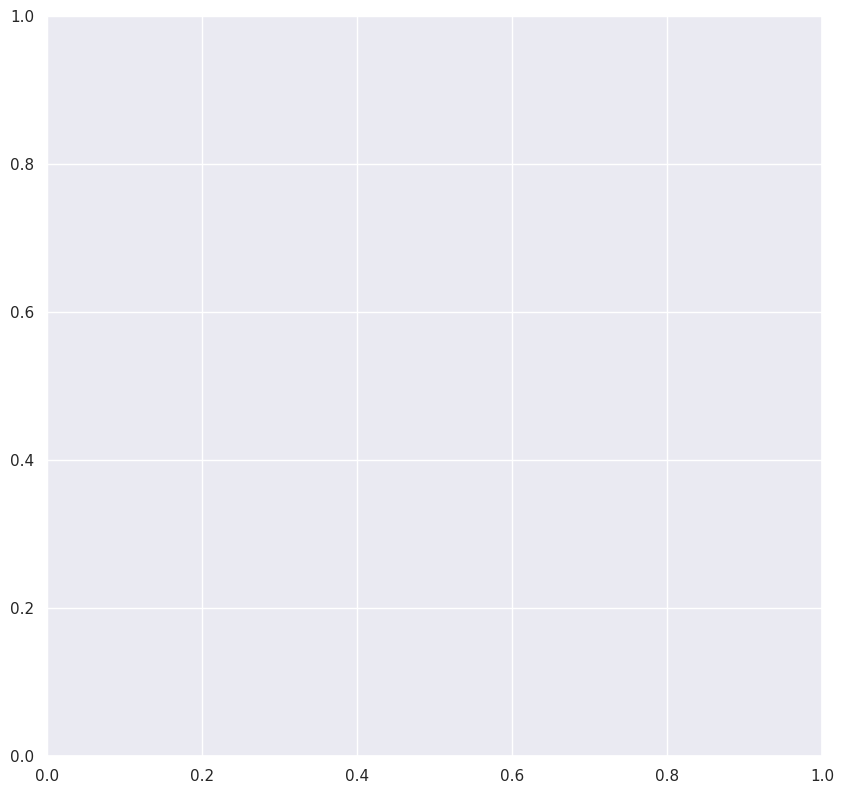

In [ ]:
# Use faulty datasets this time

fig, ax = plt.subplots(1,1, figsize = (10, 10))
plt.subplots_adjust(top=0.85, hspace=0.5)

fdr_df = pd.DataFrame(index=[f'IDV{i}' for i in range(1,21)])
    # Create an empty dataframe with columns named Fault 1, Fault 2 etc
    # FDR is the Fault Detection Rate
    # The higher the FDR, the better the model
    # IDV is the Individual Data Vector

for name, model in models.items():

    # initilize empty lists for squared prediction error and fault detection rate
    spe_test = []
    fdr = []

    for i in range(4,6):

        test_df = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]
            # select the test scenario for the current fault and the first simulation run
        spe_test.append(model.test(test_df))
            # append the corresponding spe to the spe_test list

        fault_occurrence = 20 #len(spe_test[i])//6
            # this is when the faults were injected in the actual process
            # CONSULT TO THE TENNESSEE EASTMAN PROCESS FOR MORE INFO

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))
            # consider the part of spe_test after fault occurrence for each fault type
            # whenever the mean of squared prediction errors for a feature is greater than the detection_limits value for the said feature, consider that a fault

        #color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        color = next(ax._get_lines.prop_cycler)['color']
        '''
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color=color, label=name.upper())
        ax.ravel()[i].set_xlabel('Sample')
        ax.ravel()[i].set_ylabel('SPE')
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence, color='black', ls='--')
        ax.ravel()[i].set_title(f'IDV{i+1}')
        ax.ravel()[i].set_yscale('log')

        if i==18:
            ax.plot(np.arange(len(spe_test[i])), spe_test[i], color='blue', label=name.upper())
            ax.set_xlabel('Sample')
            ax.set_ylabel('SPE')
            ax.axhline(detection_limits[name], ls='--', color = 'red')
            ax.axvline(fault_occurrence, color='black', ls='--')
            ax.set_title(f'IDV{i+1}')
            ax.set_yscale('log')
        '''
        ax.plot(np.arange(len(spe_test[i])), spe_test[i], color=color, label=name.upper())
        ax.set_xlabel('Sample')
        ax.set_ylabel('SPE')
        ax.axhline(detection_limits[name], ls='--', color = color)
        ax.axvline(fault_occurrence, color='black', ls='--')
        ax.set_title(f'IDV{i+1}')
        ax.set_yscale('log')

   # fdr_df[name] = fdr

#for subplot_object in ax.ravel():
    #subplot_object.legend(loc='lower right', ncol=4, fontsize=8)
ax.legend(loc='lower right', ncol=4, fontsize=8)

plt.show()

In [ ]:
sns.set_palette('deep')
sns.color_palette()


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

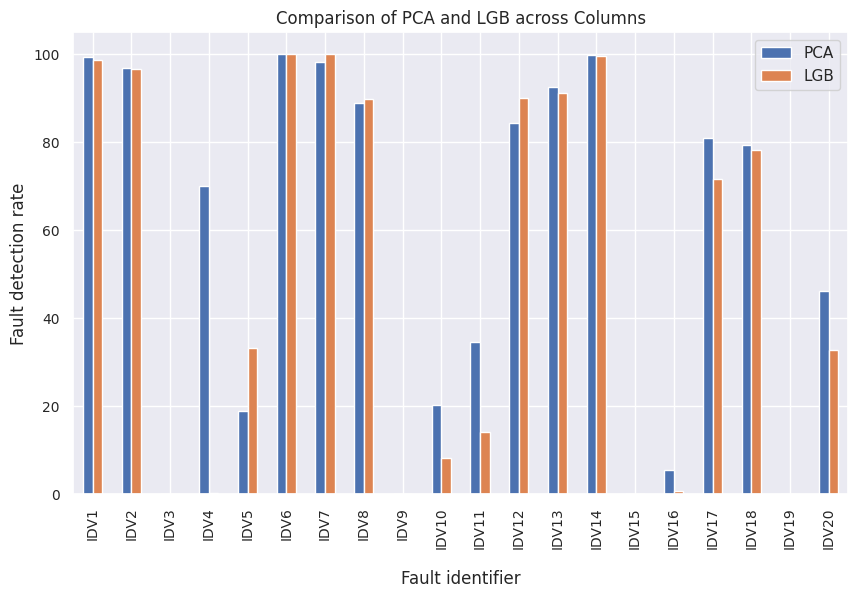

In [ ]:
plot_fdr = 100*fdr_df

new_column_names = {
    'pca': 'PCA',
    'lgb': 'LGB',
}
plot_fdr.rename(columns=new_column_names, inplace=True)

plot_fdr.plot(kind='bar', figsize=(10, 6), rot=90, fontsize=10)

# Add labels with spacing to the x-axis
plt.xlabel('Fault identifier', labelpad=15)  # Adjust the labelpad value as needed

# Add labels for the y-axis and a title
plt.ylabel('Fault detection rate')
plt.title('Comparison of PCA and LGB across Columns')

# Show the bar chart
plt.show()


(<a list of 40 Line2D ticklines objects>,
 [Text(0.0, 0, 'IDV1'),
  Text(0.3141592653589793, 0, 'IDV2'),
  Text(0.6283185307179586, 0, 'IDV3'),
  Text(0.9424777960769379, 0, 'IDV4'),
  Text(1.2566370614359172, 0, 'IDV5'),
  Text(1.5707963267948966, 0, 'IDV6'),
  Text(1.8849555921538759, 0, 'IDV7'),
  Text(2.199114857512855, 0, 'IDV8'),
  Text(2.5132741228718345, 0, 'IDV9'),
  Text(2.827433388230814, 0, 'IDV10'),
  Text(3.141592653589793, 0, 'IDV11'),
  Text(3.455751918948773, 0, 'IDV12'),
  Text(3.7699111843077517, 0, 'IDV13'),
  Text(4.084070449666731, 0, 'IDV14'),
  Text(4.39822971502571, 0, 'IDV15'),
  Text(4.71238898038469, 0, 'IDV16'),
  Text(5.026548245743669, 0, 'IDV17'),
  Text(5.340707511102648, 0, 'IDV18'),
  Text(5.654866776461628, 0, 'IDV19'),
  Text(5.969026041820607, 0, 'IDV20')])

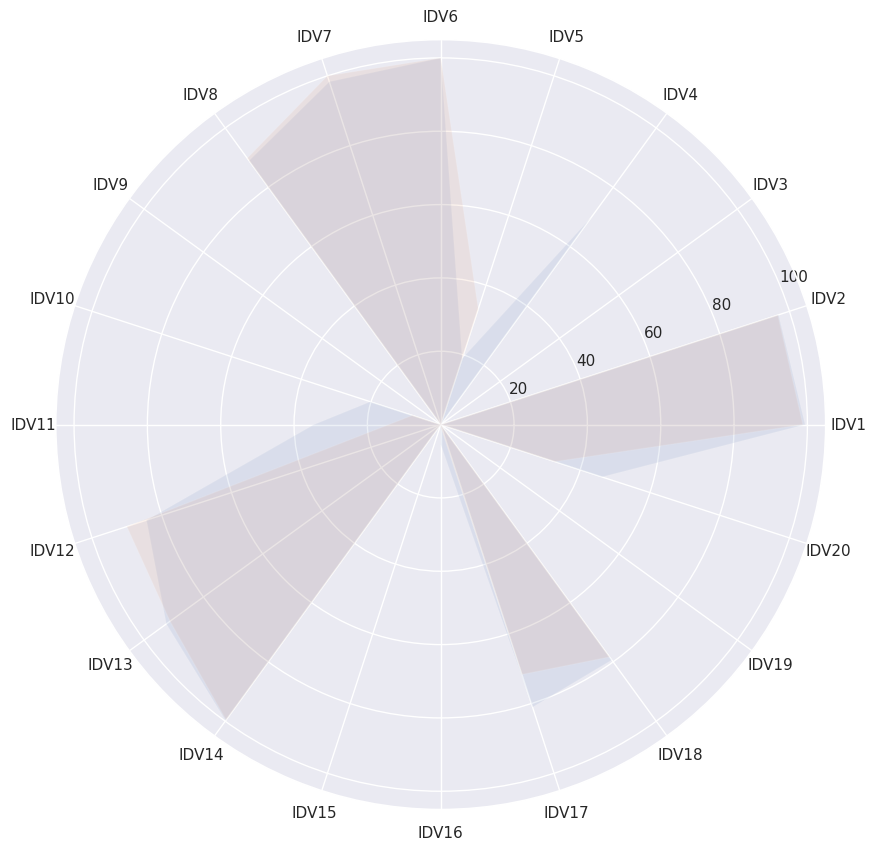

In [ ]:
fault_idv = plot_fdr.index.tolist()
col_pca = plot_fdr.iloc[:,0].tolist()
col_lgb = plot_fdr.iloc[:,1].tolist()

num_categories = len(fault_idv)

angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.fill(angles, col_pca, alpha=0.1, label='PCA')
ax.fill(angles, col_lgb, alpha=0.1, label='LGB')
ax.set_thetagrids(angles * 180/np.pi, labels=fault_idv)

In [ ]:
angles


array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
       1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
       3.14159265, 3.45575192, 3.76991118, 4.08407045, 4.39822972,
       4.71238898, 5.02654825, 5.34070751, 5.65486678, 5.96902604])

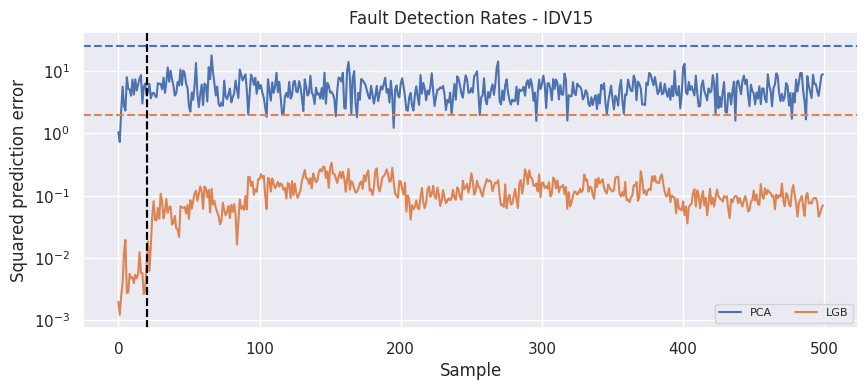

Series([], dtype: float64)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.subplots_adjust(top=0.85, hspace=0.5)

fdr_df = pd.DataFrame(index=[f'IDV{i}' for i in range(1, 21)])

colpal = sns.color_palette()

faultnum = 15

for color, (name, model) in enumerate(models.items()):
    spe_test = []
    fdr = []

    for j in range(20):
        test_df = test_faulty[(test_faulty.faultNumber == j + 1) & (test_faulty.simulationRun == 1)].iloc[:, 3:]
        spe_test.append(model.test(test_df))
        fault_occurrence = 20
        fdr.append(np.mean(spe_test[j][fault_occurrence:] > detection_limits[name]))


    ax.plot(np.arange(len(spe_test[faultnum-1])), spe_test[faultnum-1], color=colpal[color], label=name.upper())
    ax.axhline(detection_limits[name], ls='--', color=colpal[color])
    ax.axvline(fault_occurrence, color='black', ls='--')

ax.set_xlabel('Sample')
ax.set_ylabel('Squared prediction error')
ax.set_title(f'Fault Detection Rates - IDV{faultnum}')
ax.set_yscale('log')
ax.legend(loc='lower right', ncol=4, fontsize=8)

plt.show()
print(100 * fdr_df.mean())


# **APPLY LAG**

pca_lag1    60.631250
pca_lag2    59.755945
pca_lag3    60.469925
dtype: float64


IDV(1)     IDV(2)  IDV(3)  IDV(4)    IDV(5)  IDV(6)  IDV(7)  \
pca_lag1  99.625000  97.750000     0.0   100.0  9.875000   100.0   100.0   
pca_lag2  99.624531  97.747184     0.0   100.0  6.132666   100.0   100.0   
pca_lag3  99.749373  97.744361     0.0   100.0  6.892231   100.0   100.0   

             IDV(8)  IDV(9)    IDV(10)    IDV(11)    IDV(12)    IDV(13)  \
pca_lag1  95.625000     0.0  13.250000  66.750000  95.750000  89.625000   
pca_lag2  95.744681     0.0   7.008761  66.207760  95.744681  90.237797   
pca_lag3  96.741855     0.0   8.145363  70.551378  97.117794  90.977444   

             IDV(14)  IDV(15)    IDV(16)    IDV(17)    IDV(18)   IDV(19)  \
pca_lag1   97.500000      0.0  20.875000  84.250000  92.500000  3.250000   
pca_lag2   99.249061      0.0  14.392991  83.479349  92.490613  0.250313   
pca_lag3  100.000000      0.0  16.040100  84.210526  92.606516  0.250627   

            IDV(20)  
pca_lag1  46.000000  
pca_lag2  46.808511  
pca_lag3  48.370927

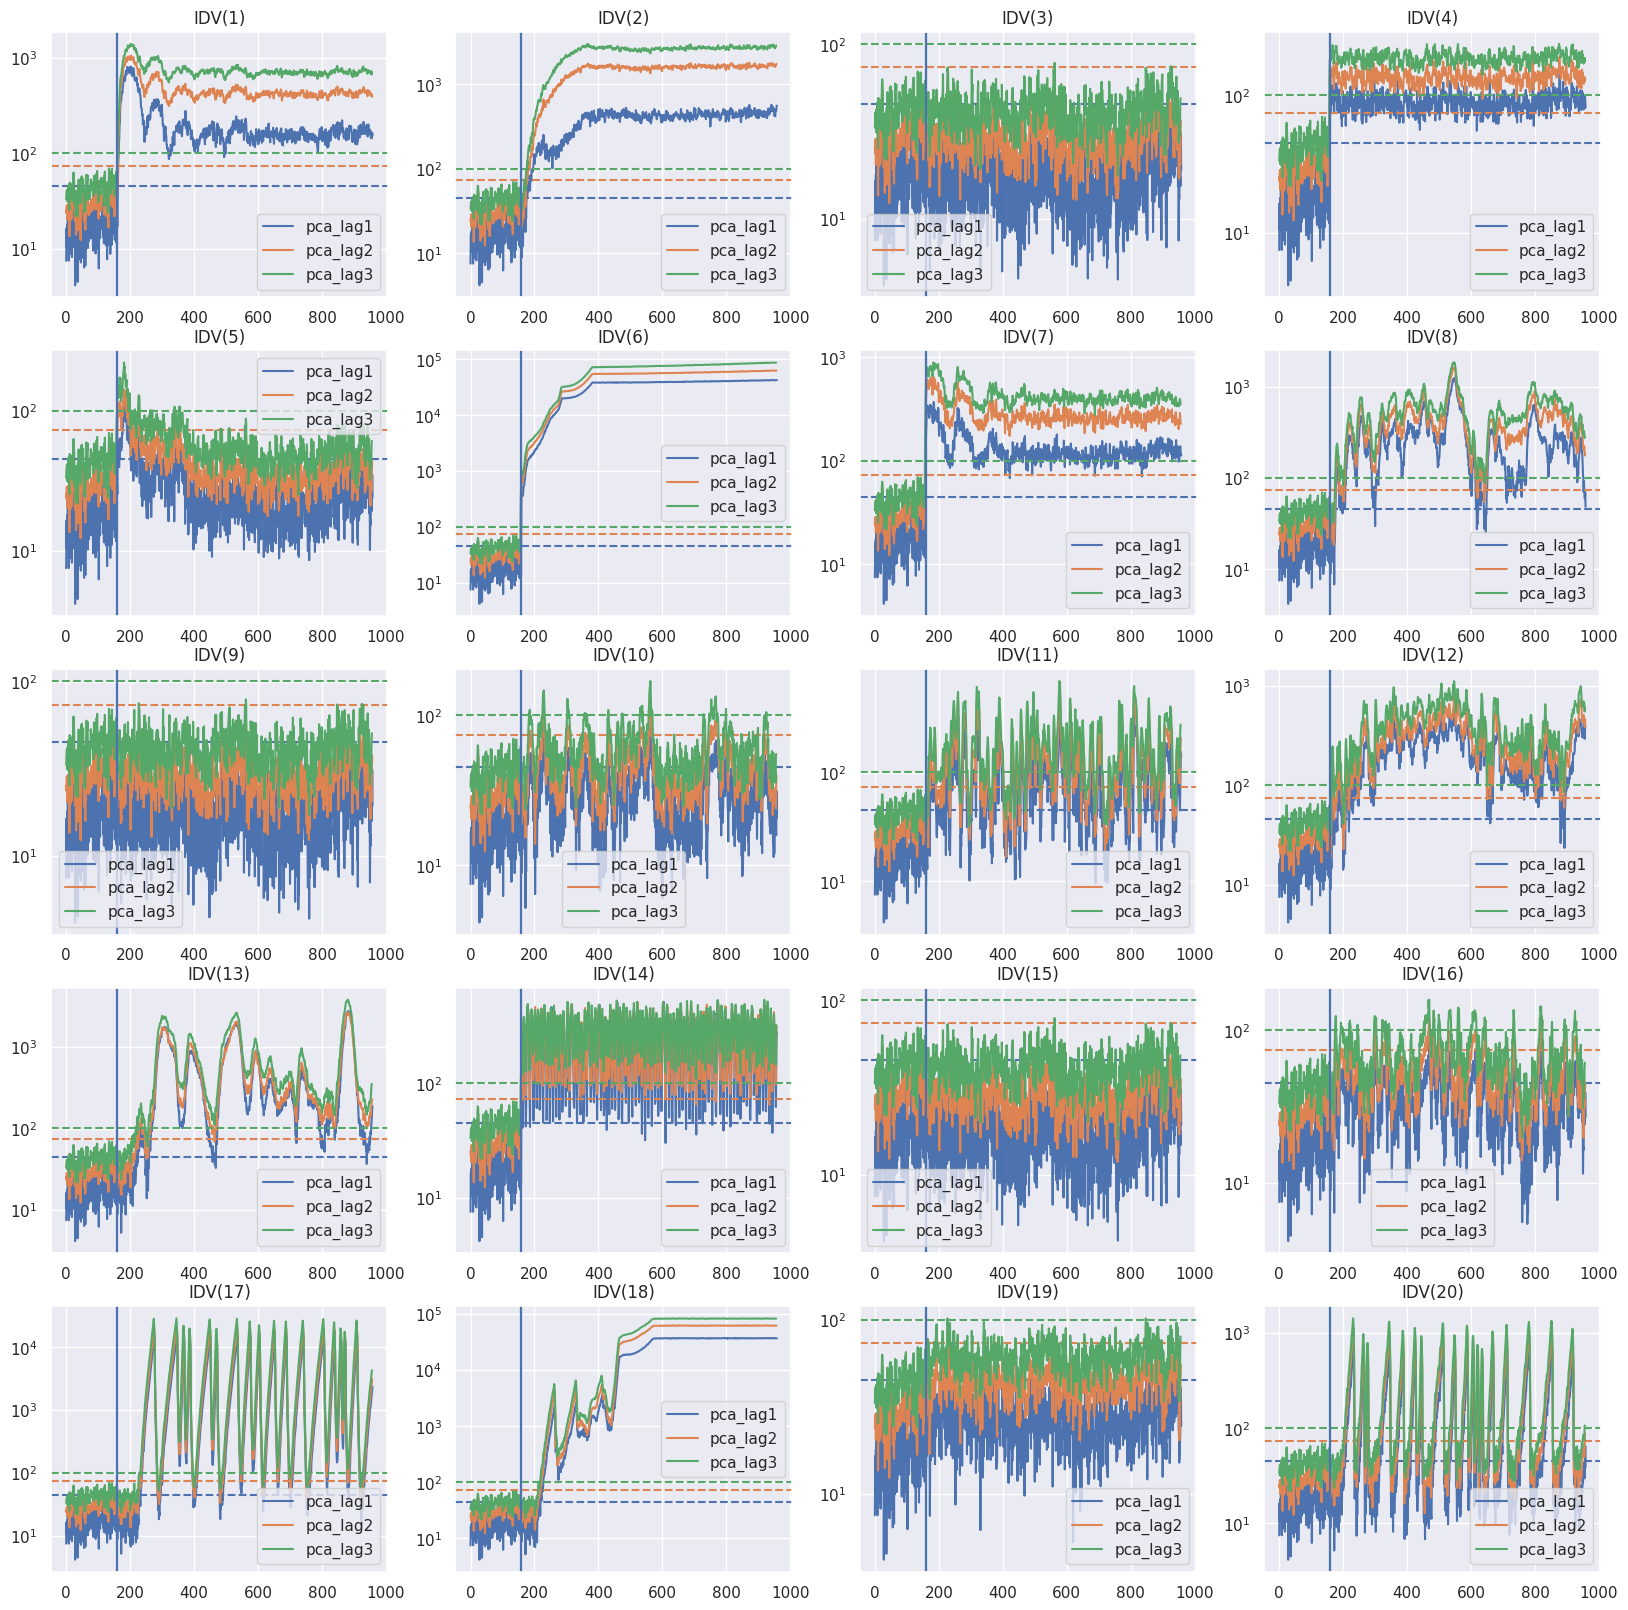

In [ ]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

train_df = train_fault_free[train_fault_free.simulationRun==1].iloc[:,3:]
validation_df = train_fault_free[(train_fault_free.simulationRun>1)&(train_fault_free.simulationRun<5)].iloc[:,3:]

lag_models = {'pca_lag1': ModelPCA(), 'pca_lag2': ModelPCA(), 'pca_lag3': ModelPCA()}
lags = {'pca_lag1': 1, 'pca_lag2': 2, 'pca_lag3': 3}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in lag_models.items():

    spe_test = []
    fdr = []

    _ = model.train(apply_lag(train_df,lags[name]))
    spe_validation = model.test(apply_lag(validation_df,lags[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):

        test_df = apply_lag(test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:], lags[name])

        spe_test.append(model.test(test_df))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'Fault({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()

    fdr_df[name] = fdr

print(100*fdr_df.mean())
100*fdr_df.T

# **APPLY FILTERS**

W10     59.700
W50     60.400
W100    59.775
dtype: float64


Fault(1)  Fault(2)  Fault(3)  Fault(4)  Fault(5)  Fault(6)  Fault(7)  \
W10     99.250    98.125       0.0     99.75    46.625    99.875    99.750   
W50     98.375    97.125       0.0     99.25    98.375    99.125    99.375   
W100    98.250    96.125       0.0     98.75    97.125    98.875    99.000   

      Fault(8)  Fault(9)  Fault(10)  Fault(11)  Fault(12)  Fault(13)  \
W10     97.375       0.0      6.125     80.000     98.500      94.25   
W50     96.375       0.0      0.125     77.250     86.125      94.00   
W100    94.375       0.0      0.000     64.625     83.750      93.00   

      Fault(14)  Fault(15)  Fault(16)  Fault(17)  Fault(18)  Fault(19)  \
W10      35.375        0.0       3.25     90.125     92.875      0.500   
W50       0.000        0.0       0.00     89.875     91.375      0.125   
W100      0.000        0.0       0.00     89.750     90.250      0.125   

      Fault(20)  
W10      52.250  
W50      81.125  
W100     91.500

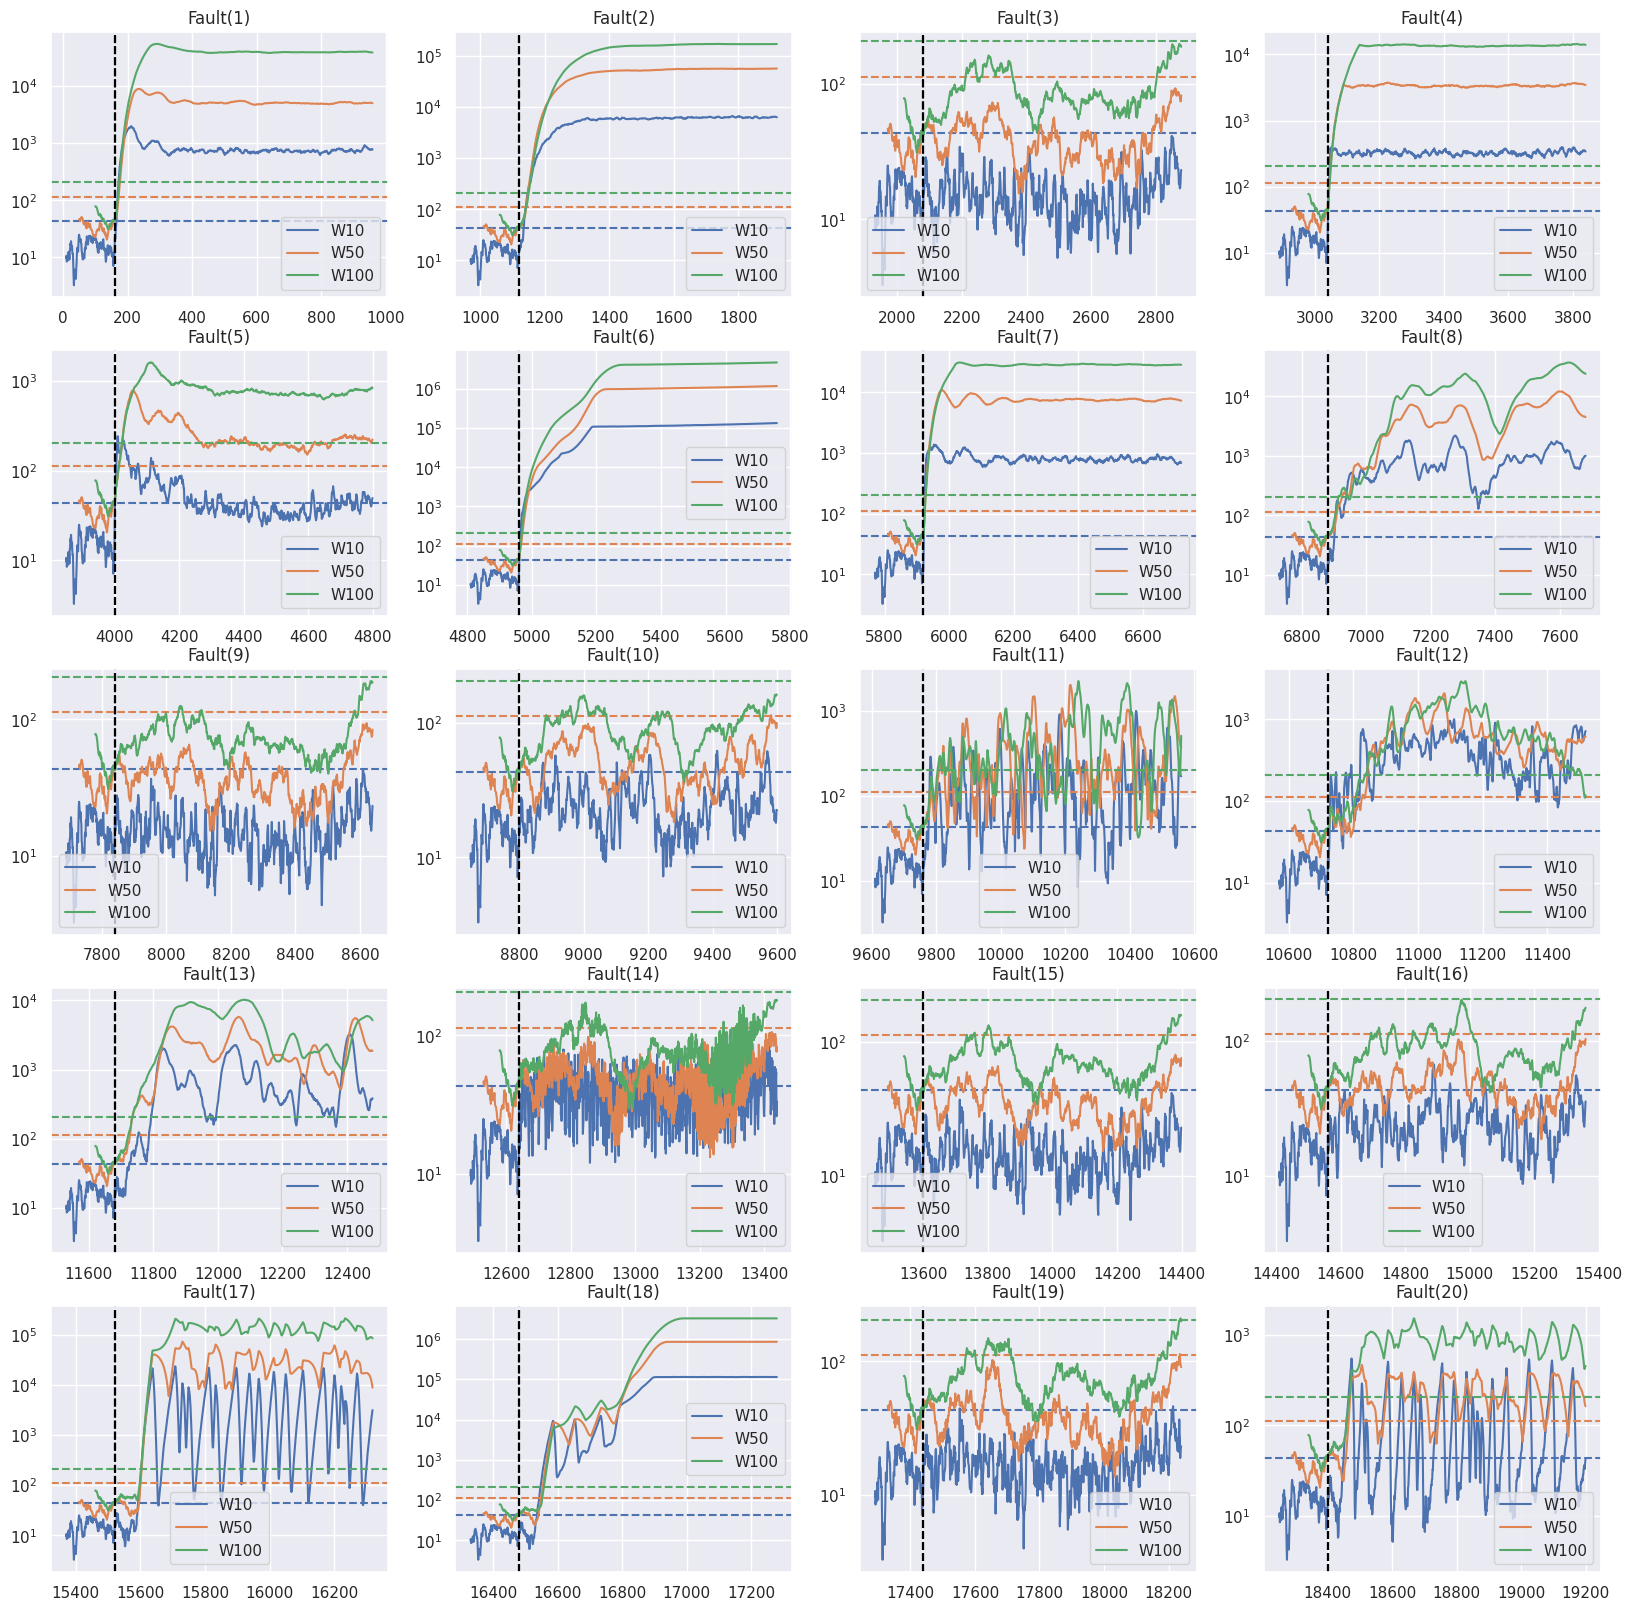

In [ ]:
# Filter PCA

fig, ax = plt.subplots(5,4, figsize = (20, 20))

train_df = train_fault_free[train_fault_free.simulationRun==1].iloc[:,3:]
validation_df = train_fault_free[(train_fault_free.simulationRun>1)&(train_fault_free.simulationRun<5)].iloc[:,3:]

window_models = {'W10': ModelPCA(), 'W50': ModelPCA(), 'W100': ModelPCA()}
window_size = {'W10': 10, 'W50': 50, 'W100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'Fault({i})' for i in range(1,21)])

for name, model in window_models.items():

    spe_test = []
    fdr = []

    _ = model.train(filter_noise_ma(train_df,window_size[name]))
    spe_validation = model.test(filter_noise_ma(validation_df, window_size[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):

        test_df = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:], window_size[name])

        spe_test.append(model.test(test_df))

        fault_occurrence = test_df.index[0]-window_size[name]+160

        fdr.append(np.mean(spe_test[i][160-window_size[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(test_df.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence, color = 'black', ls='--')
        ax.ravel()[i].set_title(f'Fault({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()

    fdr_df[name] = fdr

print(100*fdr_df.mean())
100*fdr_df.T

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training model for Reactor_feed_rate
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing wa

Fault(1)  Fault(2)  Fault(3)  Fault(4)  Fault(5)  Fault(6)  Fault(7)  \
W10     98.875     98.00       0.0    99.625    28.000    99.750    99.625   
W50     98.250     96.75       0.0    98.875    97.625    99.000    99.250   
W100    98.000     95.75       0.0    98.500    96.750    98.875    99.000   

      Fault(8)  Fault(9)  Fault(10)  Fault(11)  Fault(12)  Fault(13)  \
W10     97.125       0.0      5.375     67.250     97.750     93.750   
W50     95.250       0.0      2.750     68.125     84.750     93.375   
W100    93.625       0.0      0.000     55.125     82.625     92.125   

      Fault(14)  Fault(15)  Fault(16)  Fault(17)  Fault(18)  Fault(19)  \
W10         9.0        0.0      3.125     85.125     92.375        0.0   
W50         0.0        0.0      0.000     89.625     90.875        0.0   
W100        0.0        0.0      0.000     89.625     90.125        0.0   

      Fault(20)  
W10      35.500  
W50      63.750  
W100     91.125

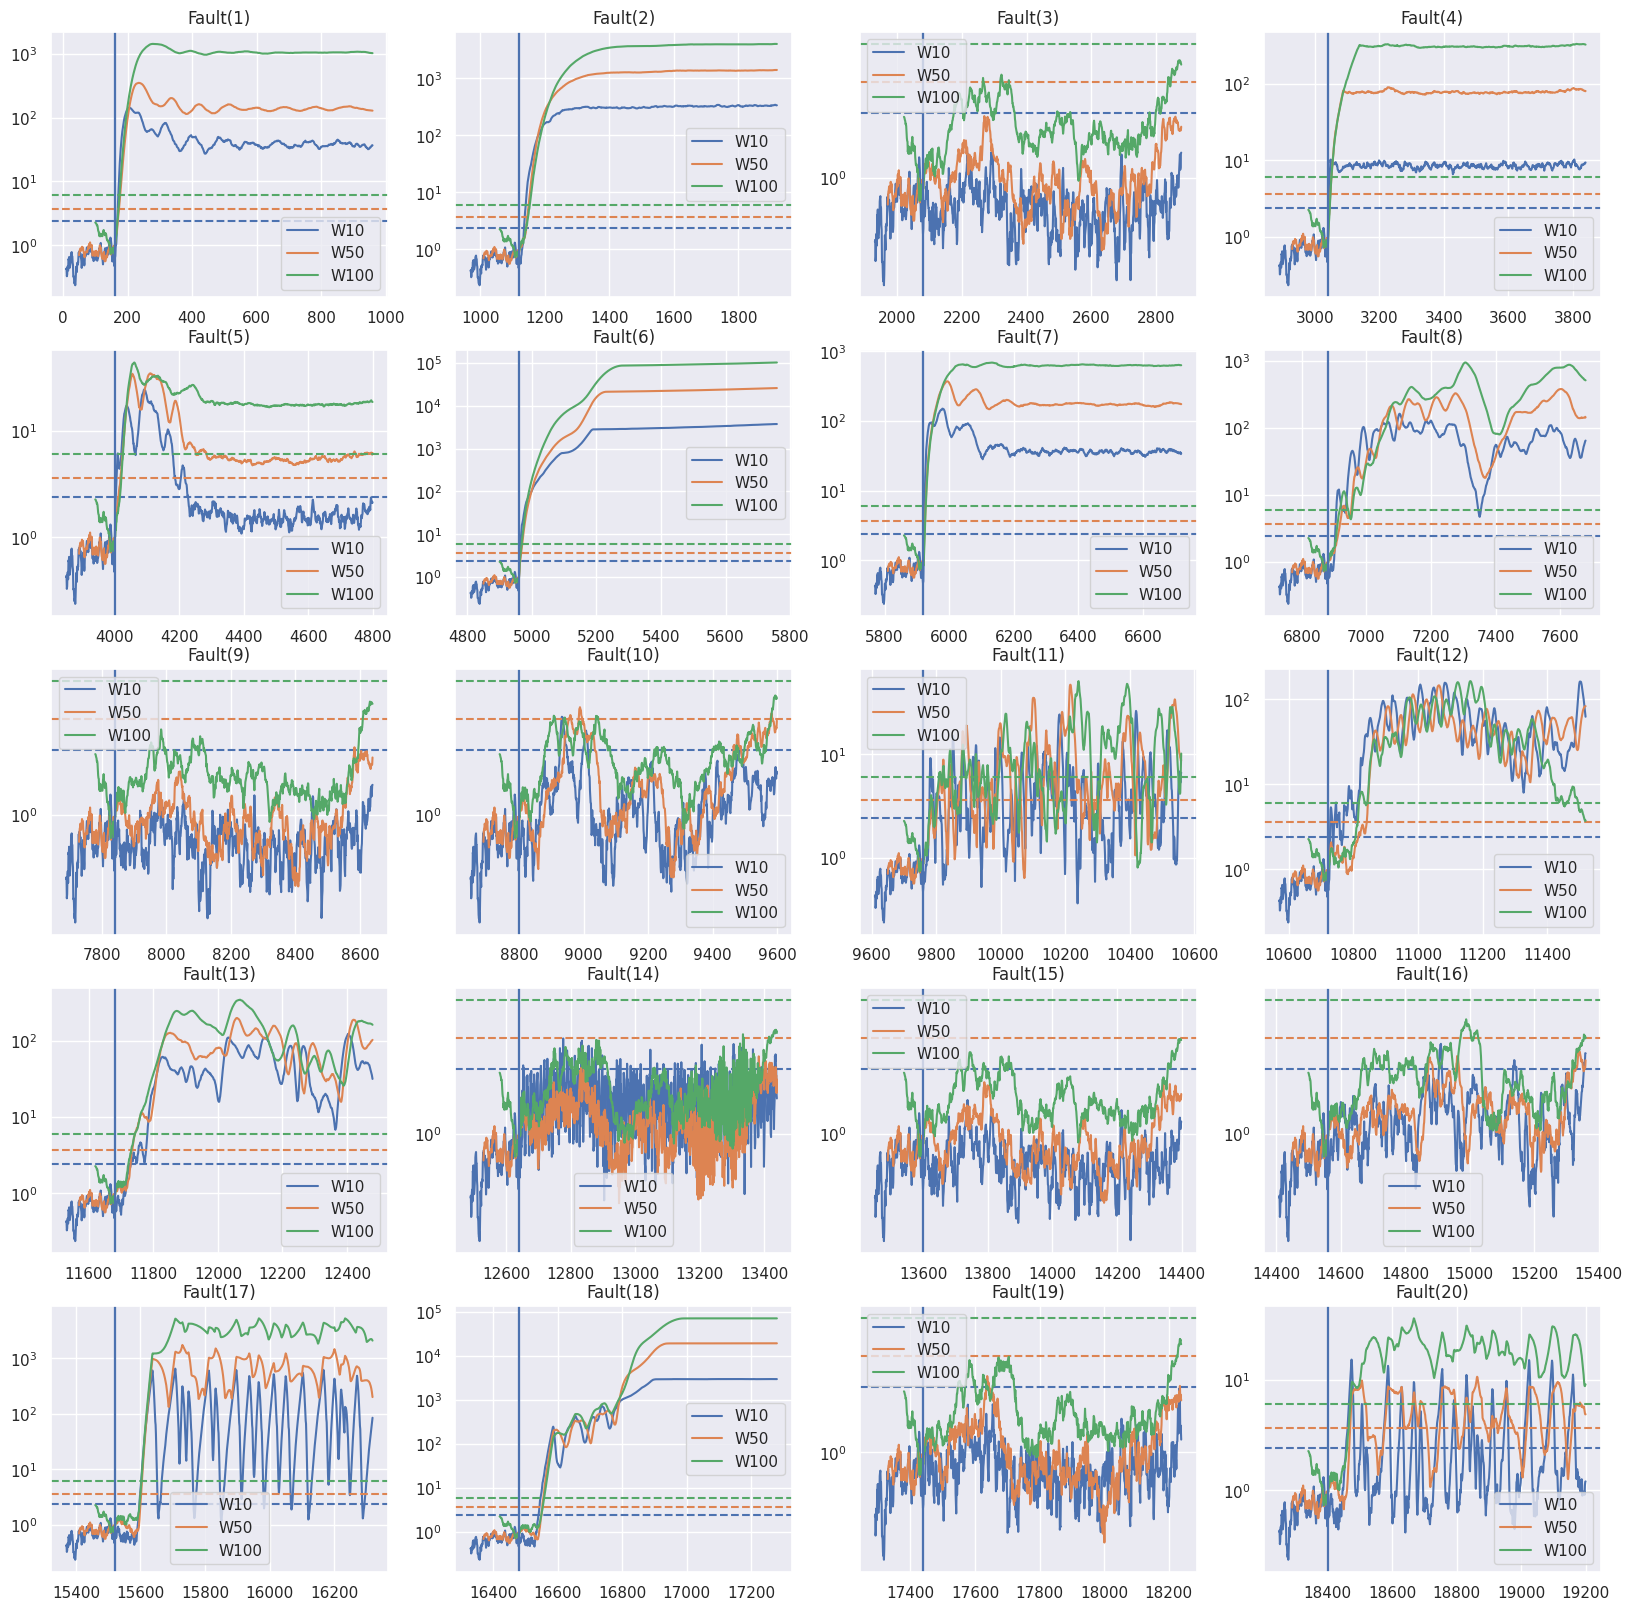

In [ ]:
# Filter LGB

fig, ax = plt.subplots(5,4, figsize = (20, 20))

train_df = train_fault_free[train_fault_free.simulationRun==1].iloc[:,3:]
validation_df = train_fault_free[(train_fault_free.simulationRun>1)&(train_fault_free.simulationRun<5)].iloc[:,3:]

regression_method = lgb.LGBMRegressor

window_models = {'W10': ModelEnsembleRegressors(regression_method), 'W50': ModelEnsembleRegressors(regression_method), 'W100': ModelEnsembleRegressors(regression_method)}
window_size = {'W10': 10, 'W50': 50, 'W100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'Fault({i})' for i in range(1,21)])

for name, model in window_models.items():

    spe_test = []
    fdr = []

    _ = model.train(filter_noise_ma(train_df,window_size[name]))
    spe_validation = model.test(filter_noise_ma(validation_df, window_size[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):

        test_df = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) &
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], window_size[name])

        spe_test.append(model.test(test_df))

        fault_occurrence = test_df.index[0]-window_size[name]+160

        fdr.append(np.mean(spe_test[i][160-window_size[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(test_df.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'Fault({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()

    fdr_df[name] = fdr

print(100*fdr_df.mean())
100*fdr_df.T